# Graph-Based Image Segmentation Using Union-Find (Felzenszwalb–Huttenlocher Algorithm)

This notebook implements the FH algorithm from scratch with a custom Union-Find (path compression + union by rank), dynamic image loading (upload/sample/URL/path), analysis, and visualizations.
It is both google colab and machine ready implementation.


## 1) Environment setup


In [108]:
import sys, subprocess

IN_COLAB = 'google.colab' in sys.modules

def run(cmd):
    try:
        subprocess.check_call(cmd, shell=True)
    except Exception as e:
        print('Command failed:', cmd, e)

if IN_COLAB:
    run('pip -q install numpy matplotlib scikit-image requests pillow')

%matplotlib inline


## 2) Imports
Only allowed libraries for I/O and visualization are used here.


In [109]:
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import requests
from skimage import io as skio, data as skdata
from skimage.transform import resize
from skimage.filters import gaussian


## 3) Image loading utilities (upload, sample, URL, path) and preprocessing
A single function `load_image_dynamic` drives selection via `source_type` and returns a preprocessed image with constrained size.


In [ ]:
try:
    from google.colab import files  # type: ignore
    IN_COLB = True
except Exception:
    IN_COLB = False


def get_sample_image(name='coffee'):
    loaders = {
        'coffee': lambda: skdata.coffee(),
        'astronaut': lambda: skdata.astronaut(),
        'camera': lambda: skdata.camera(),
        'coins': lambda: skdata.coins(),
        'moon': lambda: skdata.moon(),
        'rocket': lambda: skdata.rocket(),
        'chelsea': lambda: skdata.chelsea(),
        'horse': lambda: skdata.horse(),
    }
    if name in loaders:
        return loaders[name]()
    else:
        return skdata.astronaut()

def preprocess_image(image, max_size=512, convert_to_rgb=True):
    # Remove trasparency channel if present
    if convert_to_rgb and image.ndim == 3 and image.shape[2] == 4:
        image = image[:, :, :3]
    h, w = image.shape[:2]
    if max(h, w) > max_size:
        scale = max_size / max(h, w)
        nh, nw = int(h * scale), int(w * scale)
        image = resize(image, (nh, nw), anti_aliasing=True, preserve_range=True).astype(np.uint8)
    return image


def load_image(source_type='sample', sample_name='coffee', local_path=None, url=None, max_size=512):
    if source_type == 'sample':
        img = get_sample_image(sample_name)
    elif source_type == 'url':
        if not url:
            raise ValueError('URL not provided')
        resp = requests.get(url, timeout=10)
        print(resp)
        resp.raise_for_status()
        img = skio.imread(BytesIO(resp.content))
    elif source_type == 'path':
        if not local_path:
            raise ValueError('local_path not provided')
        img = skio.imread(local_path)
    elif source_type == 'upload':
        if not IN_COLB:
            raise RuntimeError("Upload works only on Colab; use source_type='path' locally.")
        up = files.upload()
        if not up:
            raise RuntimeError('No file uploaded')
        fname = next(iter(up.keys()))
        img = skio.imread(fname)
    else:
        raise ValueError("Invalid source_type: choose 'sample' | 'url' | 'path' | 'upload'")


    img = preprocess_image(img, max_size=max_size, convert_to_rgb=True)
    info = {
        'shape': img.shape,
        'dtype': str(img.dtype),
        'is_color': bool(img.ndim == 3),
        'pixels': int(img.shape[0] * img.shape[1])
    }
    print('Loaded image info:', info)
    return img


In [125]:
my_img = load_image(source_type='sample', sample_name='coffee', local_path='../img-segmentation/assets/demo-shot.png', url=None, max_size=512)
print()


Loaded image info: {'shape': (341, 512, 3), 'dtype': 'uint8', 'is_color': True, 'pixels': 174592}



## 4) Union-Find 
Path compression and union by rank for efficient merging and component queries.


In [112]:
class UnionFind:
    def __init__(self, size:int):
        self.parent = np.arange(size)
        self.rank = np.zeros(size, dtype=np.int32)
        self.num_sets = int(size)

    def find(self, x:int) -> int:
        # Path compression
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return int(self.parent[x])

    def union(self, x:int, y:int):
        # Union by rank
        rootx = self.find(x)
        rooty = self.find(y)
        if rootx != rooty:
            if self.rank[rootx] < self.rank[rooty]:
                self.parent[rootx] = rooty
            elif self.rank[rootx] > self.rank[rooty]:
                self.parent[rooty] = rootx
            else:
                self.parent[rooty] = rootx
                self.rank[rootx] += 1
            self.num_sets -= 1



**Quick check: Union-Find:**
We create a small Union-Find, perform unions/finds, and verify path compression and union by rank conceptually.


In [113]:
# Small Union-Find demo
uf_demo = UnionFind(10)
uf_demo.union(1, 2)
uf_demo.union(2, 3)
uf_demo.union(5, 6)
print('Find(3):', uf_demo.find(3))
print('Find(6):', uf_demo.find(6))
print('Num subgraphs before union(3,6):', uf_demo.num_sets)
uf_demo.union(3, 6)
print('Num subgraphs after union(3,6):', uf_demo.num_sets)


Find(3): 1
Find(6): 5
Num subgraphs before union(3,6): 7
Num subgraphs after union(3,6): 6


In [114]:
print('Find(3):', uf_demo.find(3))
print('Find(6):', uf_demo.find(6))

Find(3): 1
Find(6): 1


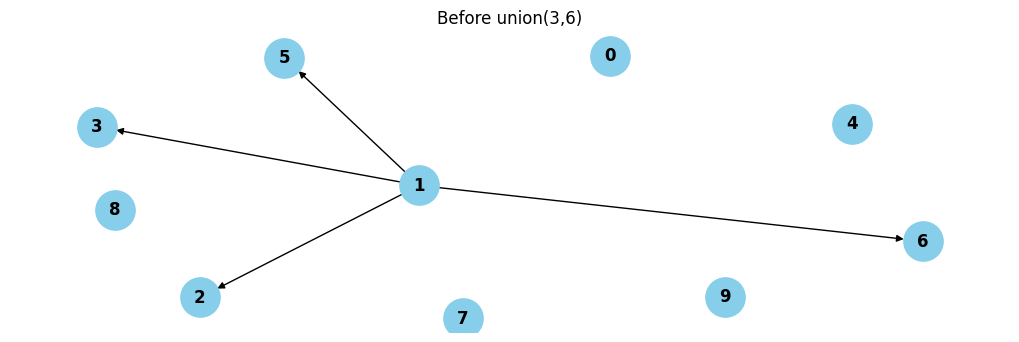

Find(3): 1
Find(0): 0
Num subgraphs before union(3,0): 6
Num subgraphs after union(3,0): 5


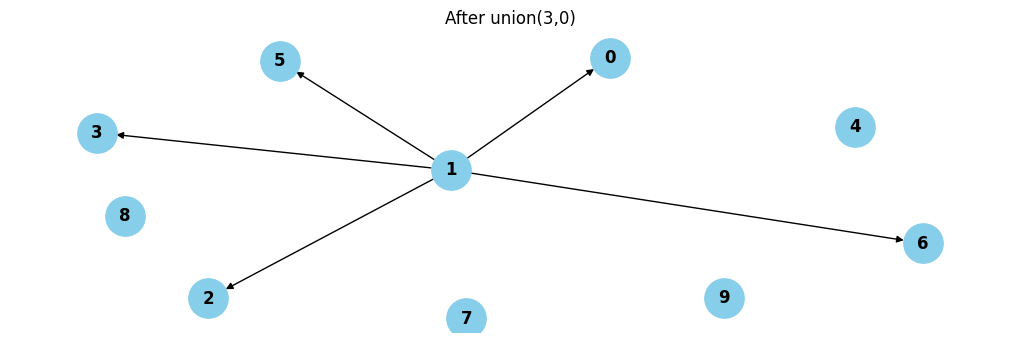

In [115]:
import networkx as nx
#  Helper function to draw Union-Find sets
def draw_union_find(uf, title):
    G = nx.DiGraph()
    for i in range(len(uf.parent)):
        G.add_node(i)
        if uf.parent[i] != i:
            G.add_edge(uf.parent[i], i)
    
    pos = nx.spring_layout(G, seed=42)  # Consistent layout
    plt.figure(figsize=(10, 3))
    nx.draw(G, pos, with_labels=True, node_size=800,
            node_color="skyblue", font_weight="bold", arrows=True)
    plt.title(title)
    plt.show()

#Visualization before merging (3,0)
draw_union_find(uf_demo, "Before union(3,6)")

print('Find(3):', uf_demo.find(3))
print('Find(0):', uf_demo.find(0))
print('Num subgraphs before union(3,0):', uf_demo.num_sets)

# Perform the union and visualize again
uf_demo.union(3, 0)
print('Num subgraphs after union(3,0):', uf_demo.num_sets)
draw_union_find(uf_demo, "After union(3,0)")

## 5) FH algorithm implementation
- Build graph edges between 4-neighbors with weights from squared differences (float-safe)
- Sort edges in ascending order
- Merge using adaptive threshold and final small-component merging
- Produce random-colored segment visualization

In [116]:
def create_graph(image: np.ndarray):
    h, w = image.shape[:2]
    is_color = image.ndim == 3
    edges = []
    for y in range(h):
        for x in range(w):
            u = y * w + x
            if x < w - 1:
                v = y * w + (x + 1)
                if is_color:
                    diff = np.sum((image[y, x].astype(np.float32) - image[y, x+1].astype(np.float32)) ** 2)
                else:
                    diff = (float(image[y, x]) - float(image[y, x+1])) ** 2
                edges.append((diff, u, v))
            if y < h - 1:
                v = (y + 1) * w + x
                if is_color:
                    diff = np.sum((image[y, x].astype(np.float32) - image[y+1, x].astype(np.float32)) ** 2)
                else:
                    diff = (float(image[y, x]) - float(image[y+1, x])) ** 2
                edges.append((diff, u, v))
    edges.sort(key=lambda e: e[0])
    return edges


def fh_segment(image: np.ndarray, k: float = 50.0, min_size: int = 10, sigma: float = 0.8):
    h, w = image.shape[:2]
    n = h * w
    is_color = image.ndim == 3

    # Gaussian smoothing (float-safe, preserve_range)
    if sigma > 0:
        if is_color:
            smoothed = gaussian(image, sigma=sigma, channel_axis=-1, preserve_range=True)
        else:
            smoothed = gaussian(image, sigma=sigma, preserve_range=True)
    else:
        smoothed = image.astype(np.float32)

    edges = create_graph(smoothed)
    uf = UnionFind(n)

    # Threshold array per component root (initialized to k)
    threshold = np.full(n, float(k), dtype=np.float32)

    # Merge pass
    for wgt, u, v in edges:
        ru, rv = uf.find(u), uf.find(v)
        if ru == rv:
            continue
        mint = min(threshold[ru], threshold[rv])
        if wgt <= mint:
            uf.union(ru, rv)
            new_root = uf.find(ru)
            threshold[new_root] = float(wgt) + float(k)

    # Small component merging
    if min_size > 0:
        # compute sizes by root
        roots = np.array([uf.find(i) for i in range(n)])
        sizes = {r: int((roots == r).sum()) for r in np.unique(roots)}
        for wgt, u, v in edges:
            ru, rv = uf.find(u), uf.find(v)
            if ru != rv:
                su, sv = sizes.get(ru, 1), sizes.get(rv, 1)
                if su < min_size or sv < min_size:
                    uf.union(ru, rv)
                    nr = uf.find(ru)
                    sizes[nr] = su + sv

    # Build random-colored segmented image
    seg = np.zeros_like(image, dtype=np.uint8)
    colors = {}
    for y in range(h):
        for x in range(w):
            r = uf.find(y * w + x)
            if r not in colors:
                if is_color:
                    colors[r] = np.random.randint(0, 255, size=3, dtype=np.uint8)
                else:
                    colors[r] = np.uint8(np.random.randint(0, 255))
            seg[y, x] = colors[r]

    return seg, uf.num_sets, uf


In [117]:
# check the FH segmentation function with my_img
segmented_img, num_segments, uf_result = fh_segment(my_img, k=100.0, min_size=30, sigma=0.8)
print(f'Segmented into {num_segments} segments.')


Segmented into 34 segments.


## 6) Analysis helpers
- Count segments, extract top-N largest segments and masks


In [118]:
def analyze_segments(original_image: np.ndarray, uf: UnionFind, top_n:int=9):
    h, w = original_image.shape[:2]
    n = h * w
    roots = np.array([uf.find(i) for i in range(n)])
    unique, counts = np.unique(roots, return_counts=True)
    sizes = dict(zip(unique.tolist(), counts.tolist()))

    # Largest components
    items = sorted(sizes.items(), key=lambda kv: kv[1], reverse=True)[:top_n]
    segments = []
    info = []
    for idx, (root, size) in enumerate(items, start=1):
        mask = (roots.reshape(h, w) == root)
        seg = np.zeros_like(original_image)
        seg[mask] = original_image[mask]
        segments.append(seg)
        info.append({'id': idx, 'root': int(root), 'size': int(size), 'mask': mask})

    return {
        'total_segments': int(uf.num_sets),
        'largest_segments': segments,
        'segment_info': info,
        'component_sizes': sizes}


In [119]:
# Analyze segments
analysis = analyze_segments(my_img, uf_result, top_n=9)

print(analysis.get('total_segments'))
print(analysis.get('component_sizes'))


34
{2105: 6134, 8431: 39, 19723: 25217, 34649: 691, 50535: 125, 60436: 51, 62990: 84, 66434: 72, 73311: 140066, 88825: 70, 89307: 70, 89850: 48, 90361: 36, 99142: 49, 102991: 95, 103944: 163, 104448: 43, 105794: 87, 111293: 68, 114689: 84, 119595: 97, 122141: 115, 125207: 58, 126261: 97, 128826: 162, 134441: 57, 135972: 95, 139375: 59, 144505: 149, 156564: 55, 165614: 67, 166125: 109, 169074: 141, 169456: 39}


## 7) Visualization helpers
- Side-by-side comparison of original and segmented
- Gallery of largest segments
- Parameter comparison plots


In [120]:
def show_comparison(original, segmented, titles=("Original", "Segmented")):
    fig, axes = plt.subplots(1, 2, figsize=(16,5))
    if original.ndim == 2:
        axes[0].imshow(original, cmap='gray')
    else:
        axes[0].imshow(original)
    axes[0].set_title(titles[0])
    axes[0].axis('off')

    if segmented.ndim == 2:
        axes[1].imshow(segmented, cmap='gray')
    else:
        axes[1].imshow(segmented)
    axes[1].set_title(titles[1])
    axes[1].axis('off')
    plt.tight_layout()
    return fig


def show_segment_gallery(segments, segment_info, grid=(3,3)):
    r, c = grid
    fig, axes = plt.subplots(r, c, figsize=(16, 12))
    axes = np.array(axes).reshape(r, c)
    for i in range(r):
        for j in range(c):
            idx = i * c + j
            ax = axes[i, j]
            if idx < len(segments):
                seg = segments[idx]
                info = segment_info[idx]
                if seg.ndim == 2:
                    ax.imshow(seg, cmap='gray')
                else:
                    ax.imshow(seg)
                ax.set_title(f"Segment {info['id']} | size={info['size']}")
            else:
                ax.axis('off')
    plt.tight_layout()
    return fig


def plot_param_comparison(reports, param_name:str):
    x, y, m = [], [], []
    for rep in reports:
        x.append(rep['parameters'][param_name])
        y.append(rep['total_segments'])
        m.append(rep['statistics']['mean_size'])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
    ax1.plot(x, y, 'o-', color='red')
    ax1.set_xlabel(param_name)
    ax1.set_ylabel('Number of segments')
    ax1.grid(True, alpha=0.3)
    ax1.set_title(f'Segments vs {param_name}')

    ax2.plot(x, m, 'o-', color='blue')
    ax2.set_xlabel(param_name)
    ax2.set_ylabel('Mean segment size')
    ax2.grid(True, alpha=0.3)
    ax2.set_title(f'Mean size vs {param_name}')
    plt.tight_layout()
    return fig


## 8) Demo: load image and run single segmentation
Configure the source and parameters, then visualize results and analyze segments.


Loaded image info: {'shape': (341, 512, 3), 'dtype': 'uint8', 'is_color': True, 'pixels': 174592}
Total segments: 93 | k=30, min_size=50, sigma=0.8


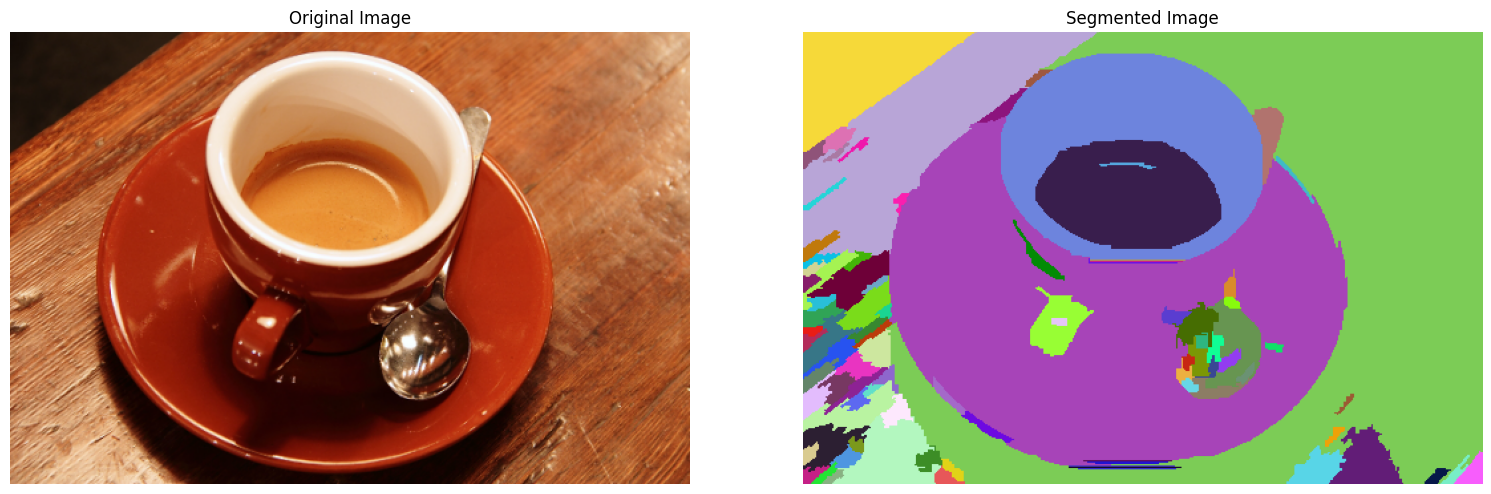

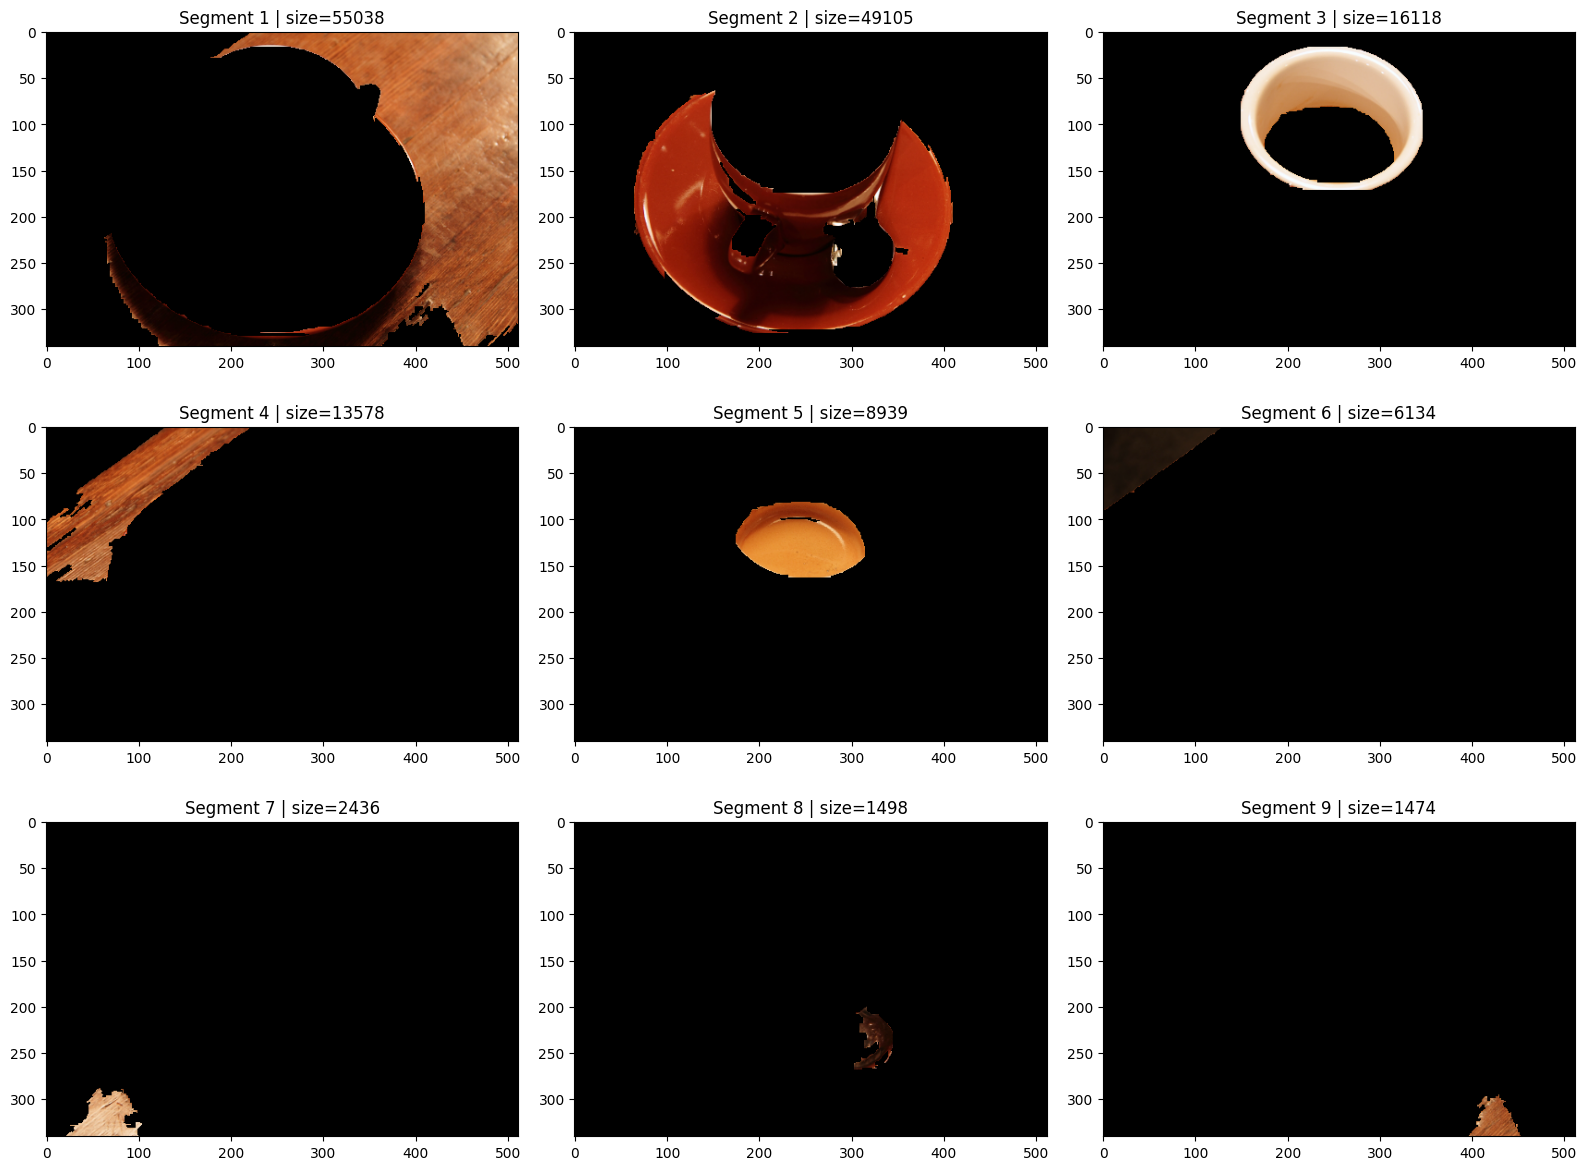

In [121]:
# Choose source: 'sample' | 'url' | 'path' | 'upload' 
source_type = 'sample'
sample_name = 'coffee'
local_path = None  
url = None

image = load_image(source_type, sample_name=sample_name, local_path=local_path, url=url, max_size=512)

k, min_size, sigma = 30, 50, 0.8
segments, num_segments, uf = fh_segment(image, k=k, min_size=min_size, sigma=sigma)
print(f'Total segments: {num_segments} | k={k}, min_size={min_size}, sigma={sigma}')
show_comparison(image, segments, titles=("Original Image", "Segmented Image")) 
plt.show()

analysis_result = analyze_segments(image, uf, top_n=9)
show_segment_gallery(analysis_result['largest_segments'], analysis_result['segment_info'])
plt.show()

## 9) Parameter sweeps and comparison plots
We vary `k`, `min_size`, and `sigma` independently and compare their effects.


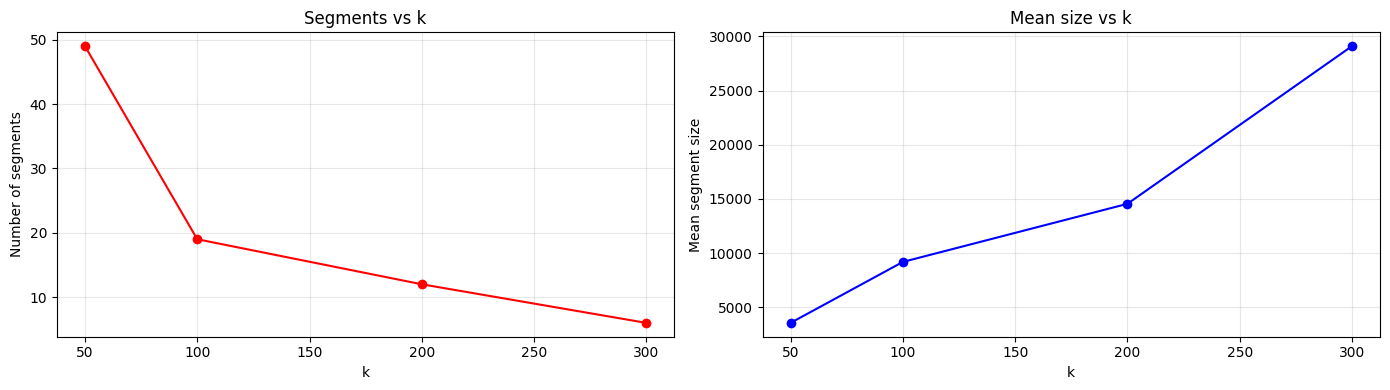

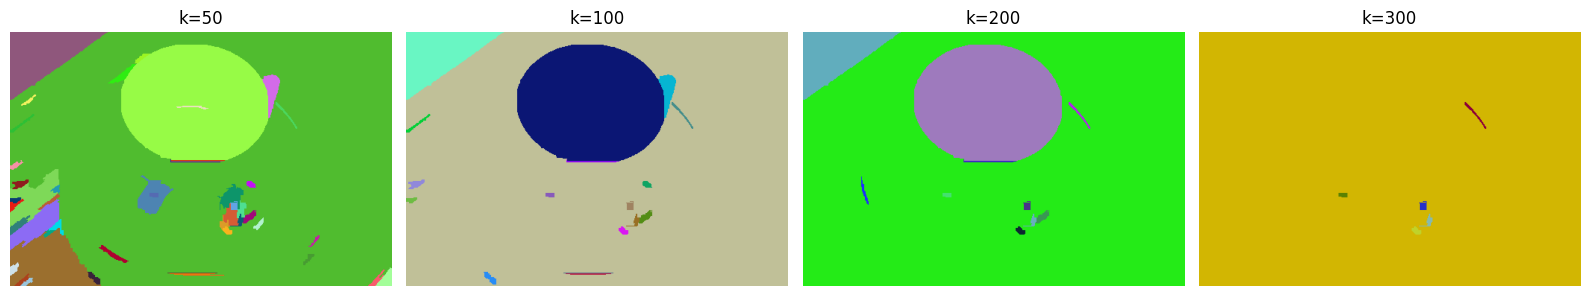

In [122]:
def generate_report(analysis_results, params):
    sizes = list(analysis_results['component_sizes'].values())
    sizes = sizes if sizes else [0]
    return {
        'parameters': {
            'k': float(params['k']),
            'min_size': int(params['min_size']),
            'sigma': float(params['sigma'])
        },
        'total_segments': int(analysis_results['total_segments']),
        'statistics': {
            'mean_size': float(np.mean(sizes)),
            'median_size': float(np.median(sizes)),
            'std_size': float(np.std(sizes)),
            'min_size': int(np.min(sizes)),
            'max_size': int(np.max(sizes))
        }
    }


def run_param_sweep(image, base_k=100, base_min_size=50, base_sigma=0.8, vary='k', values=(50, 100, 200, 300)):
    reports, samples = [], []
    for v in values:
        k, ms, sg = base_k, base_min_size, base_sigma
        if vary == 'k':
            k = v
        elif vary == 'min_size':
            ms = v
        elif vary == 'sigma':
            sg = v
        seg, _, uf_obj = fh_segment(image, k=k, min_size=ms, sigma=sg)
        analysis = analyze_segments(image, uf_obj, top_n=9)
        rep = generate_report(analysis, {'k': k, 'min_size': ms, 'sigma': sg})
        reports.append(rep)
        samples.append((v, seg))
    return reports, samples

# Sweep k
rep_k, samp_k = run_param_sweep(image, vary='k', values=(50, 100, 200, 300))
plot_param_comparison(rep_k, 'k')
plt.show()

# Show first few outputs
fig, axes = plt.subplots(1, min(4, len(samp_k)), figsize=(16,4))
for ax, (val, im) in zip(axes, samp_k[:4]):
    if im.ndim == 2:
        ax.imshow(im, cmap='gray')
    else:
        ax.imshow(im)
    ax.set_title(f'k={val}')
    ax.axis('off')
plt.tight_layout() 
plt.show()


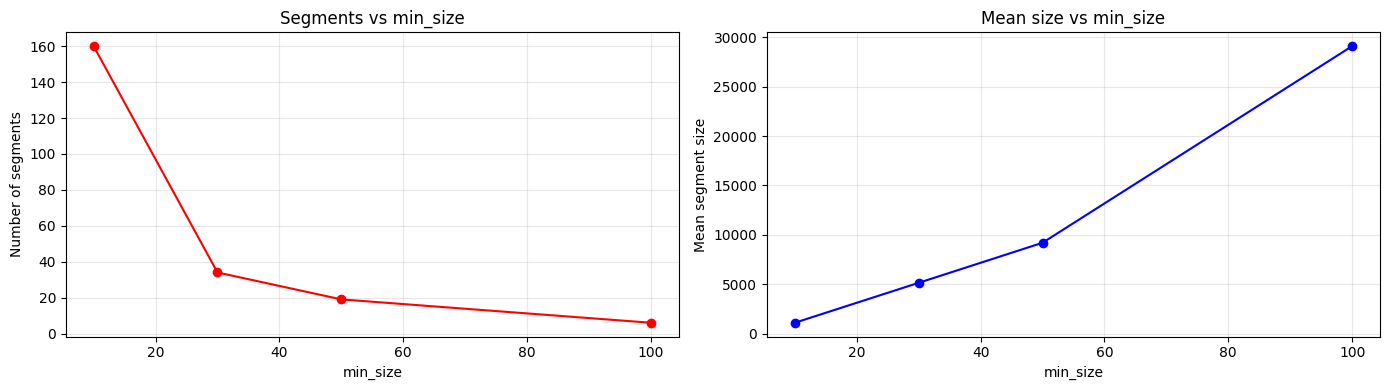

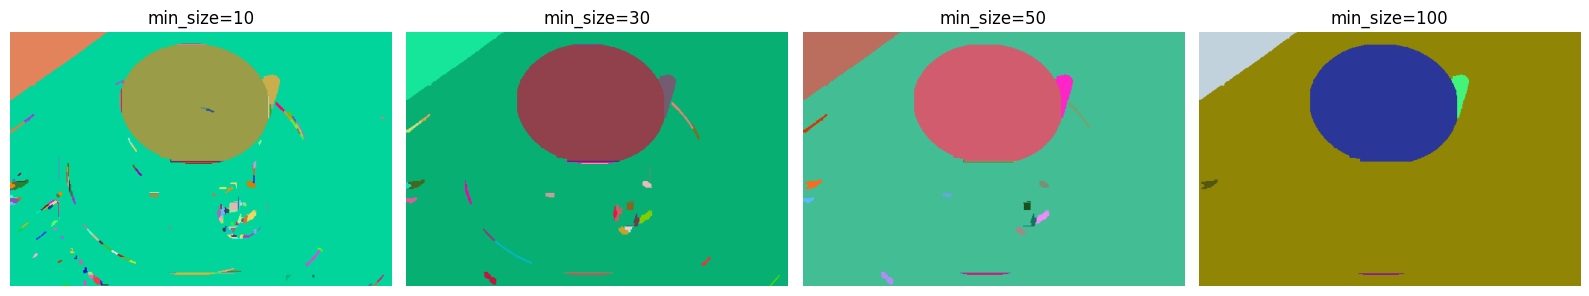

In [123]:
# sweep min_size
rep_ms, samp_ms = run_param_sweep(image, vary='min_size', values=(10, 30, 50, 100))
plot_param_comparison(rep_ms, 'min_size') 
plt.show()
#show first few outputs
fig, axes = plt.subplots(1, min(4, len(samp_ms)), figsize=(16,4))
for ax, (val, im) in zip(axes, samp_ms[:4]):
    if im.ndim == 2:
        ax.imshow(im, cmap='gray')
    else:
        ax.imshow(im)
    ax.set_title(f'min_size={val}')
    ax.axis('off')
plt.tight_layout() 
plt.show()

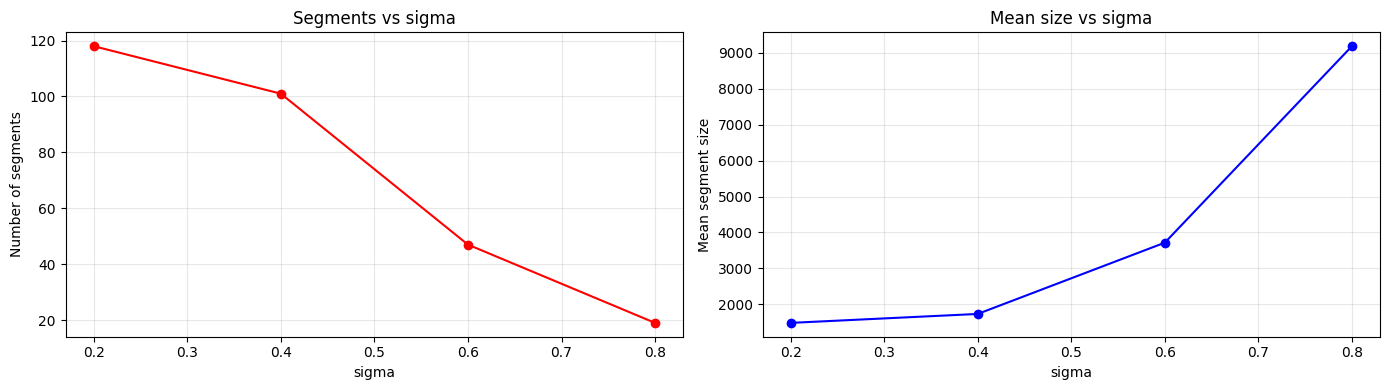

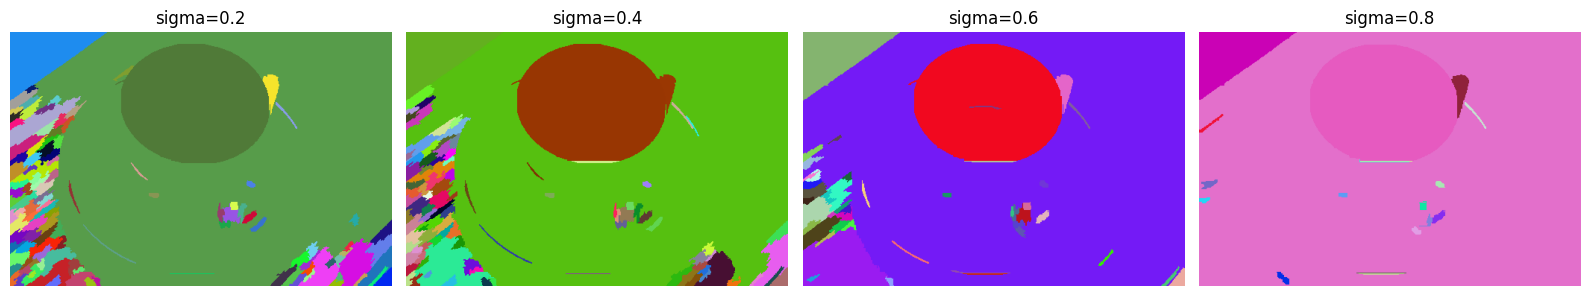

In [124]:
# sweep sigma
rep_sg, samp_sg = run_param_sweep(image, vary='sigma', values=(0.2, 0.4, 0.6, 0.8))
plot_param_comparison(rep_sg, 'sigma') 
plt.show()
#show first few outputs
fig, axes = plt.subplots(1, min(4, len(samp_sg)), figsize=(16,4))
for ax, (val, im) in zip(axes, samp_sg[:4]):
    if im.ndim == 2:
        ax.imshow(im, cmap='gray')
    else:
        ax.imshow(im)
    ax.set_title(f'sigma={val}')
    ax.axis('off')
plt.tight_layout() 
plt.show()

## 10) FH Algorithm with the Ease of Union-Find
- Build a pixel graph with 4-neighborhood edges weighted by squared differences .
- Sort edges by ascending weight and process from small to large.
- Maintain disjoint sets using Union-Find; merge components if edge weight ≤ adaptive threshold.
- Final pass merges tiny components smaller than `min_size`.
- Visualize segments by assigning random colors per component root.


## 11) Challenges and how handled
- uint8 overflow when squaring differences: handled by casting to float (`astype(np.float32)`).
- Grayscale vs. color unpacking mismatches: handled with `image.ndim` for 2D vs 3D arrays checking explicitly and simple slicing.


## 12) Summary 
- Union-Find with path compression and union by rank enables efficient component maintenance across dense pixel graphs.
- FH segmentation preserves boundaries by comparing edge weights to adaptive thresholds rather than fixed ones.
- Parameter control: increasing `k` coarsens segments; `min_size` removes small fragments; `sigma` reduces noise but can blur edges if too high.
- Robust handling of datatypes and image modes (grayscale vs. RGB) is crucial for correct and stable implementations.

In General, 
- Relationship Overview

| Parameter    | What it Controls                                               | Effect on Number of Segments                                                                                                         |
| ------------ | -------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------ |
| **k**        | Threshold for merging — controls how easily regions are joined | ↑ **k** → fewer, larger segments (more merging) <br>↓ **k** → more, smaller segments (less merging)                                  |
| **min_size** | Minimum allowable component size                               | ↑ **min_size** → fewer, larger segments (forces small regions to merge) <br>↓ **min_size** → more, smaller segments remain           |
| **sigma**    | Gaussian smoothing (preprocessing)                             | ↑ **sigma** → smoother image → fewer, larger segments <br>↓ **sigma** → noisier image, more fine detail → more segments |
